# Рекомендательная система фильмов пользователям

## Описание

Используется готовый датасет ml-latest-small.zip.
URL: https://grouplens.org/datasets/movielens/

*База данных содежит 3 основных .csv файла: links.csv, ratings.csv, movies.csv* :

* links.csv -> movieId, imdbId, tmdbId
* movies.csv -> movieId, title, genres
* rating.csv -> userId, moviId, rating, timestamp

## Листинг

Установка необходимых библиотек

In [1]:
!pip install seaborn

You should consider upgrading via the 'D:\ПИШ (Глубокое обучение нейросетей)\env\Scripts\python.exe -m pip install --upgrade pip' command.


Импортирование необходимых библиотек

In [2]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns

Загрузка синтетического набора данных и формирование матрицы предпочтений пользователей

In [3]:
# 1. Считывание данных фильмов и оценок пользователей
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

# 2. Объединение рейтингов с названием фильмов
ratings = ratings.merge(
    movies[['movieId', 'title']],
    on='movieId',
    how='left'
)

# 3. Пользователи, поставившие хотя бы одну оценку
active_users = ratings['userId'].unique()

# 4. Если пользователей больше 50, то отбирается топ-50 активных пользователей
if len(active_users) > 50:
    user_counts = ratings['userId'].value_counts()
    selected_users = user_counts.head(50).index.tolist()
else:
    selected_users = list(active_users)

# 5. Отбор данных оценок рассматриваемых пользователей
filtered = ratings[ratings['userId'].isin(selected_users)]

# 6. Выбор самых оцененных фильмов из рассматриваемых пользоваетелй
top_movies = filtered['title'].value_counts().head(50).index.tolist()

# 7. Отбор данных о выбранных фильмах
filtered = filtered[filtered['title'].isin(top_movies)]

# 8. Формирование списка пользователей и фильмов
users_raw = filtered['userId'].unique().tolist()
movies_list = filtered['title'].unique().tolist()

# 9. Поскольку в бд заданы только ID пользователей, то формируем отображение (idx, UID) -> (UID: User №)
user_map = {uid: f'User {i+1}' for i, uid in enumerate(users_raw)}
users = list(user_map.values())

# 10. Создаем матрицу предпочтений пользователей
preferences = {}
for uid in users_raw:
    user_data = filtered[filtered['userId'] == uid]
    preferences[user_map[uid]] = dict(zip(user_data['title'], user_data['rating']))

# 11. Вывод информации
print(f"Пользователей: {len(users)}")
print(f"Фильмов: {len(movies_list)}")
print("Пример preferences:")
for user, prefs in list(preferences.items())[:10]:
    print(f"{user}: {list(prefs.items())[:3]}")

Пользователей: 50
Фильмов: 50
Пример preferences:
User 1: [('Toy Story (1995)', 3.5), ('Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 4.0), ('Seven (a.k.a. Se7en) (1995)', 4.5)]
User 2: [('Toy Story (1995)', 4.0), ('Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 4.0), ('Seven (a.k.a. Se7en) (1995)', 3.0)]
User 3: [('Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 3.5), ('Seven (a.k.a. Se7en) (1995)', 3.0), ('Star Wars: Episode IV - A New Hope (1977)', 4.0)]
User 4: [('Toy Story (1995)', 5.0), ('Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 4.0), ('Star Wars: Episode IV - A New Hope (1977)', 5.0)]
User 5: [('Toy Story (1995)', 4.0), ('Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 4.0), ('Seven (a.k.a. Se7en) (1995)', 4.5)]
User 6: [('Toy Story (1995)', 2.5), ('Seven (a.k.a. Se7en) (1995)', 4.0), ('Star Wars: Episode IV - A New Hope (1977)', 5.0)]
User 7: [('Toy Story (1995)', 3.0), ('Forrest Gump (1994)', 0.5), ('Monty Python and the Holy Grail (1975)', 2.5)]
User 8: [('Toy Story (1995)', 4.0), ('Tw

Инициализация Q-таблицы нулевыми значениями

In [4]:
# Инициализация Q-таблицы
Q = defaultdict(lambda: np.zeros(len(movies_list)))

Определение функции вознаграждения

In [5]:
# Определение функции награды
def get_reward(user, movie):
    return preferences[user].get(movie, 0)

Настройка параметров обучения при помощи Q-обучения

In [6]:
# Параметры обучения
alpha = 0.1  # Скорость обучения
gamma = 0.9  # Коэффициент дисконтирования
epsilon = 0.1  # Вероятность случайного выбора действия
num_episodes = 1000  # Количество эпизодов обучения

for episode in range(num_episodes):
    user = random.choice(users)
    available_movies = movies_list.copy()
    while available_movies:
        if random.uniform(0, 1) < epsilon:
            # Случайный выбор фильма
            movie = random.choice(available_movies)
        else:
            # Выбор фильма с наибольшим Q-значением
            available_movie_indices = [movies_list.index(m) for m in available_movies]
            movie_idx = np.argmax(Q[user][available_movie_indices])
            movie = available_movies[movie_idx]
            
        reward = get_reward(user, movie)
        best_next_action = np.max(Q[user][available_movie_indices])
        # Обновление Q-таблицы
        movie_idx = movies_list.index(movie)
        Q[user][movie_idx] = Q[user][movie_idx] + alpha * (reward + gamma * best_next_action - Q[user][movie_idx])
        # Удаляем выбранный фильм из доступных
        available_movies.remove(movie)

Тестирование системы рекомендаций

In [7]:
# Тестирование системы рекомендаций
def recommend_movie(user):
    movie_idx = np.argmax(Q[user])
    return movies_list[movie_idx]

# Тестирование рекомендаций
recommendations = {}
for user in users:
    recommended_movie = recommend_movie(user)
    recommendations[user] = recommended_movie
    print(f"Recommended movie for {user}: {recommended_movie}")

Recommended movie for User 1: Shawshank Redemption, The (1994)
Recommended movie for User 2: Terminator 2: Judgment Day (1991)
Recommended movie for User 3: Pulp Fiction (1994)
Recommended movie for User 4: Monty Python and the Holy Grail (1975)
Recommended movie for User 5: Shawshank Redemption, The (1994)
Recommended movie for User 6: Star Wars: Episode VI - Return of the Jedi (1983)
Recommended movie for User 7: Toy Story (1995)
Recommended movie for User 8: Pirates of the Caribbean: The Curse of the Black Pearl (2003)
Recommended movie for User 9: Fight Club (1999)
Recommended movie for User 10: Forrest Gump (1994)
Recommended movie for User 11: Lord of the Rings: The Return of the King, The (2003)
Recommended movie for User 12: Mrs. Doubtfire (1993)
Recommended movie for User 13: American Beauty (1999)
Recommended movie for User 14: Men in Black (a.k.a. MIB) (1997)
Recommended movie for User 15: Star Wars: Episode IV - A New Hope (1977)
Recommended movie for User 16: Monty Python 

Вывод диаграммы рекомендаций

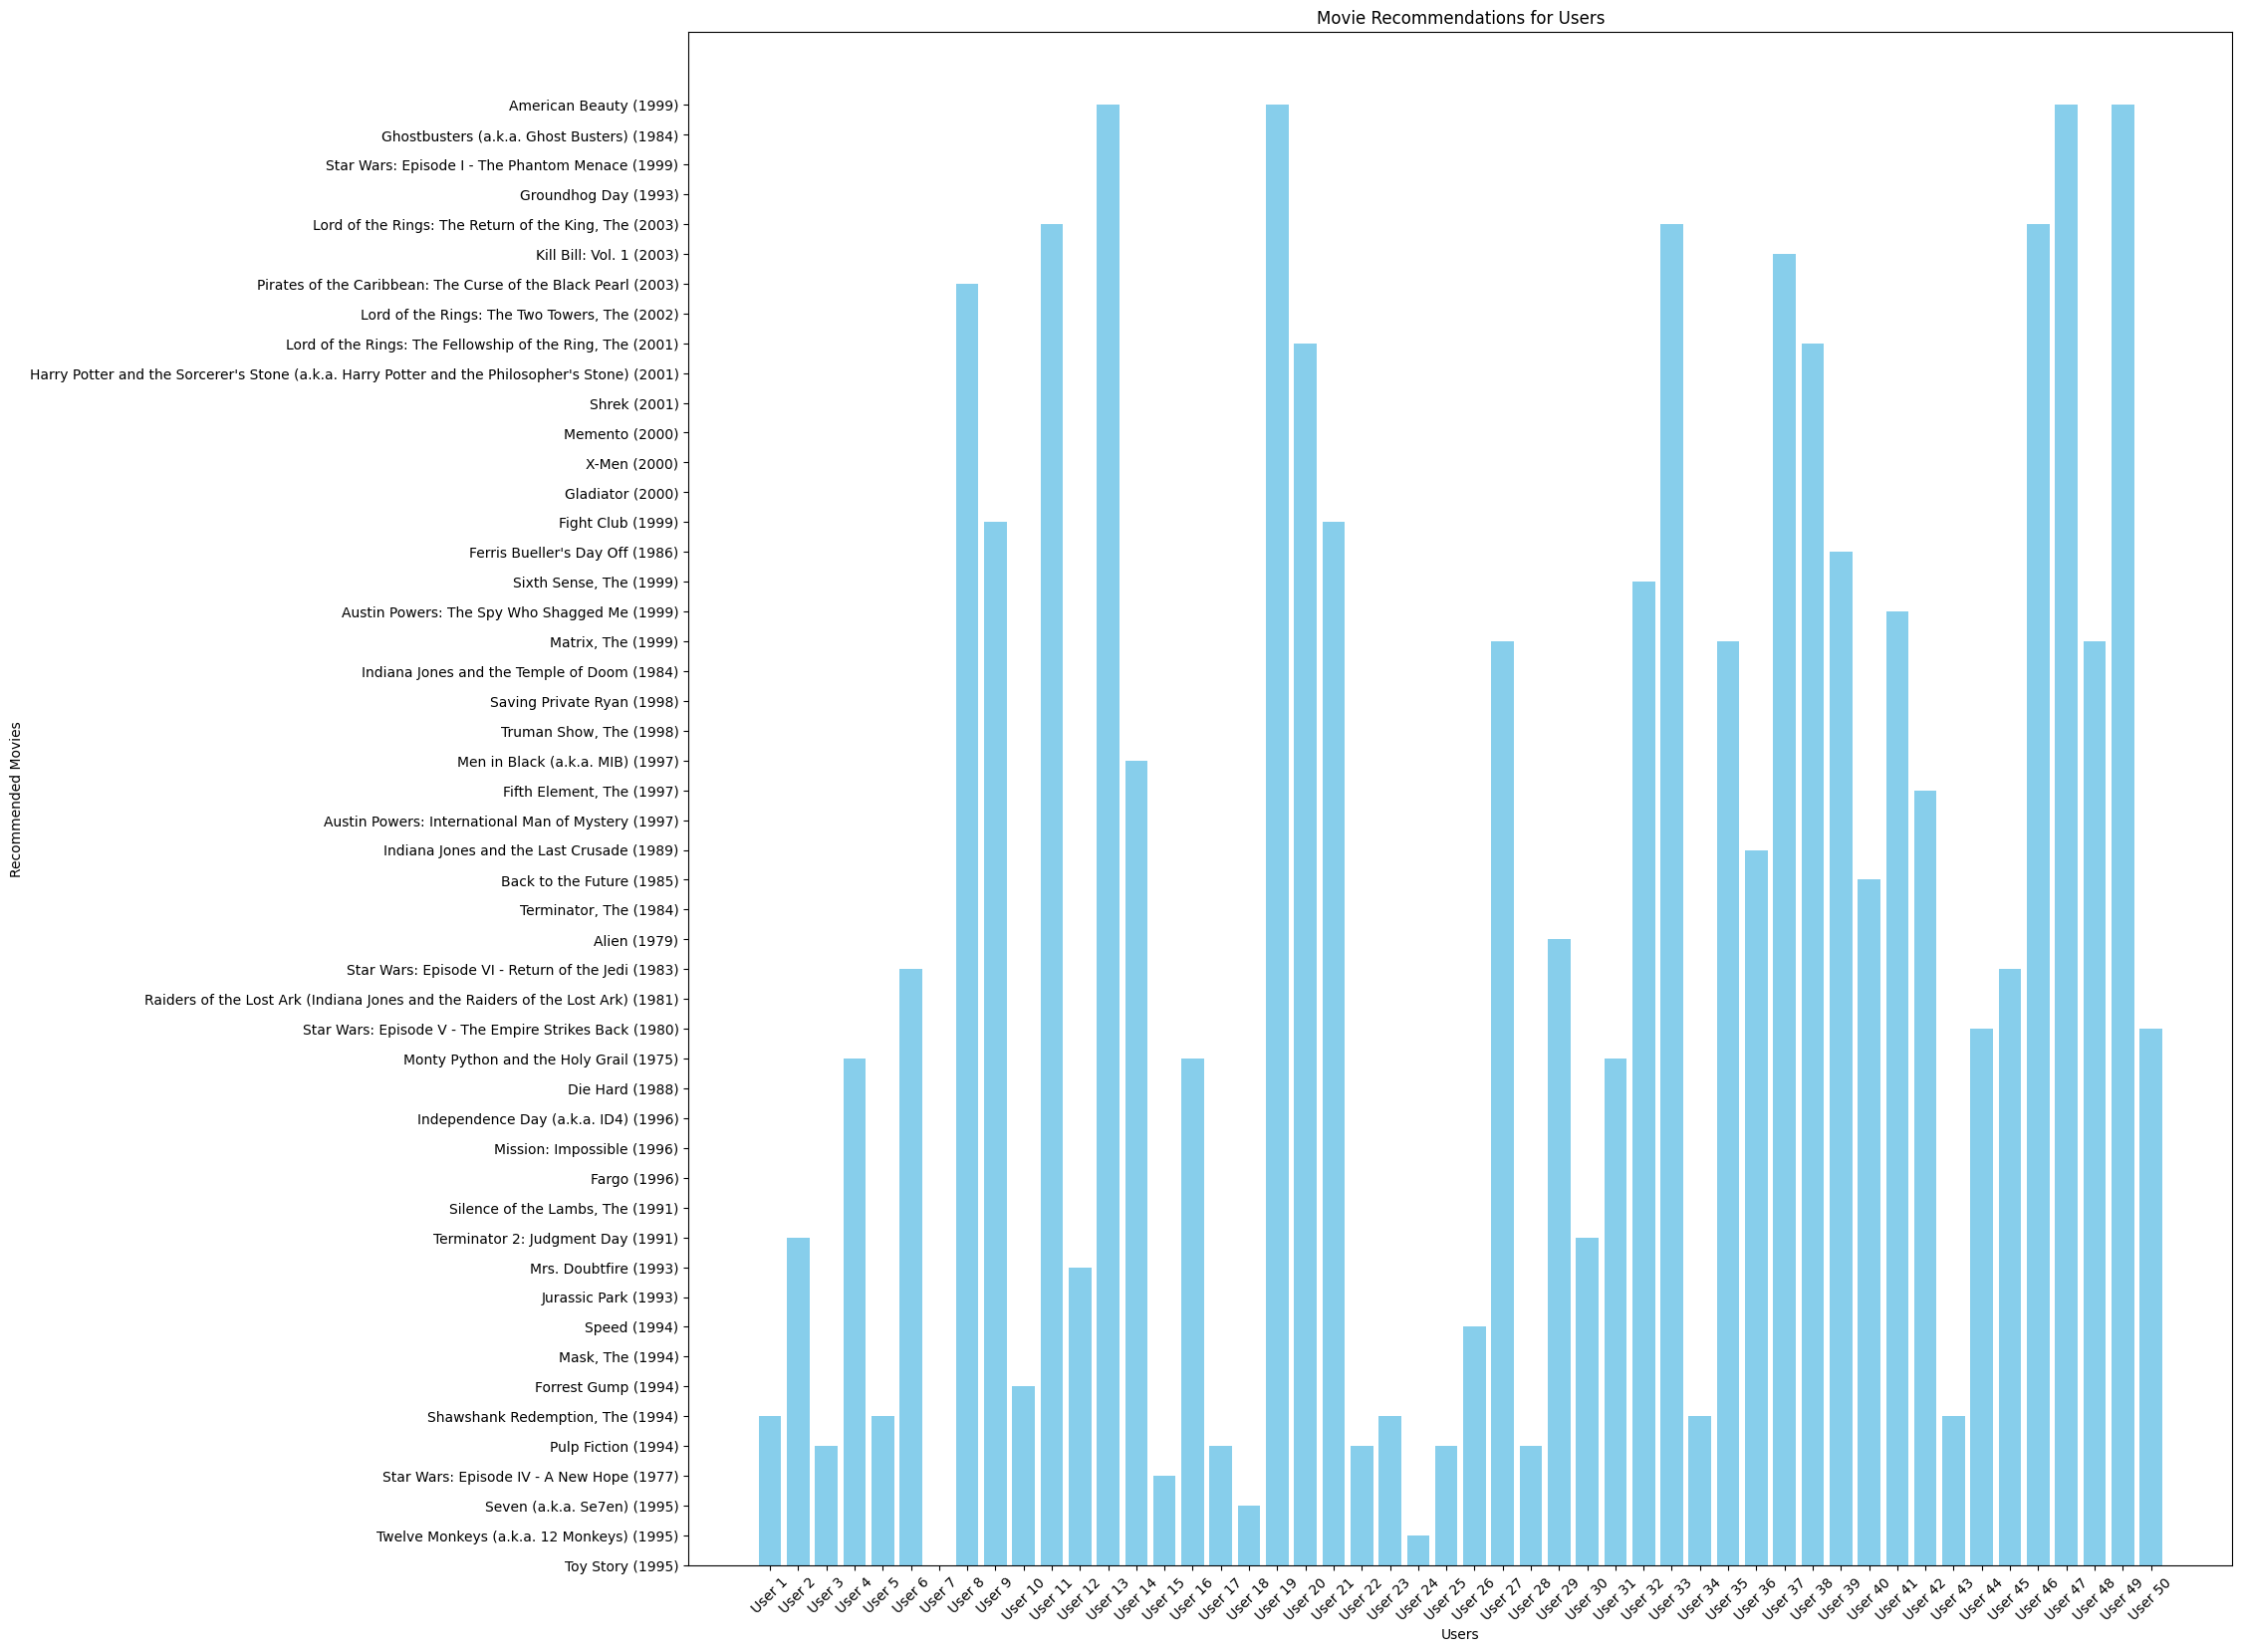

In [8]:
# Визуализация рекомендаций
plt.figure(figsize=(20, 20))
plt.bar(recommendations.keys(), [movies_list.index(movie) for movie in recommendations.values()], color='skyblue')
plt.xticks(rotation=45)
plt.yticks(range(len(movies_list)), movies_list)
plt.xlabel('Users')
plt.ylabel('Recommended Movies')
plt.title('Movie Recommendations for Users')
plt.show()

Визуализация итоговой-обновленной Q-таблицы

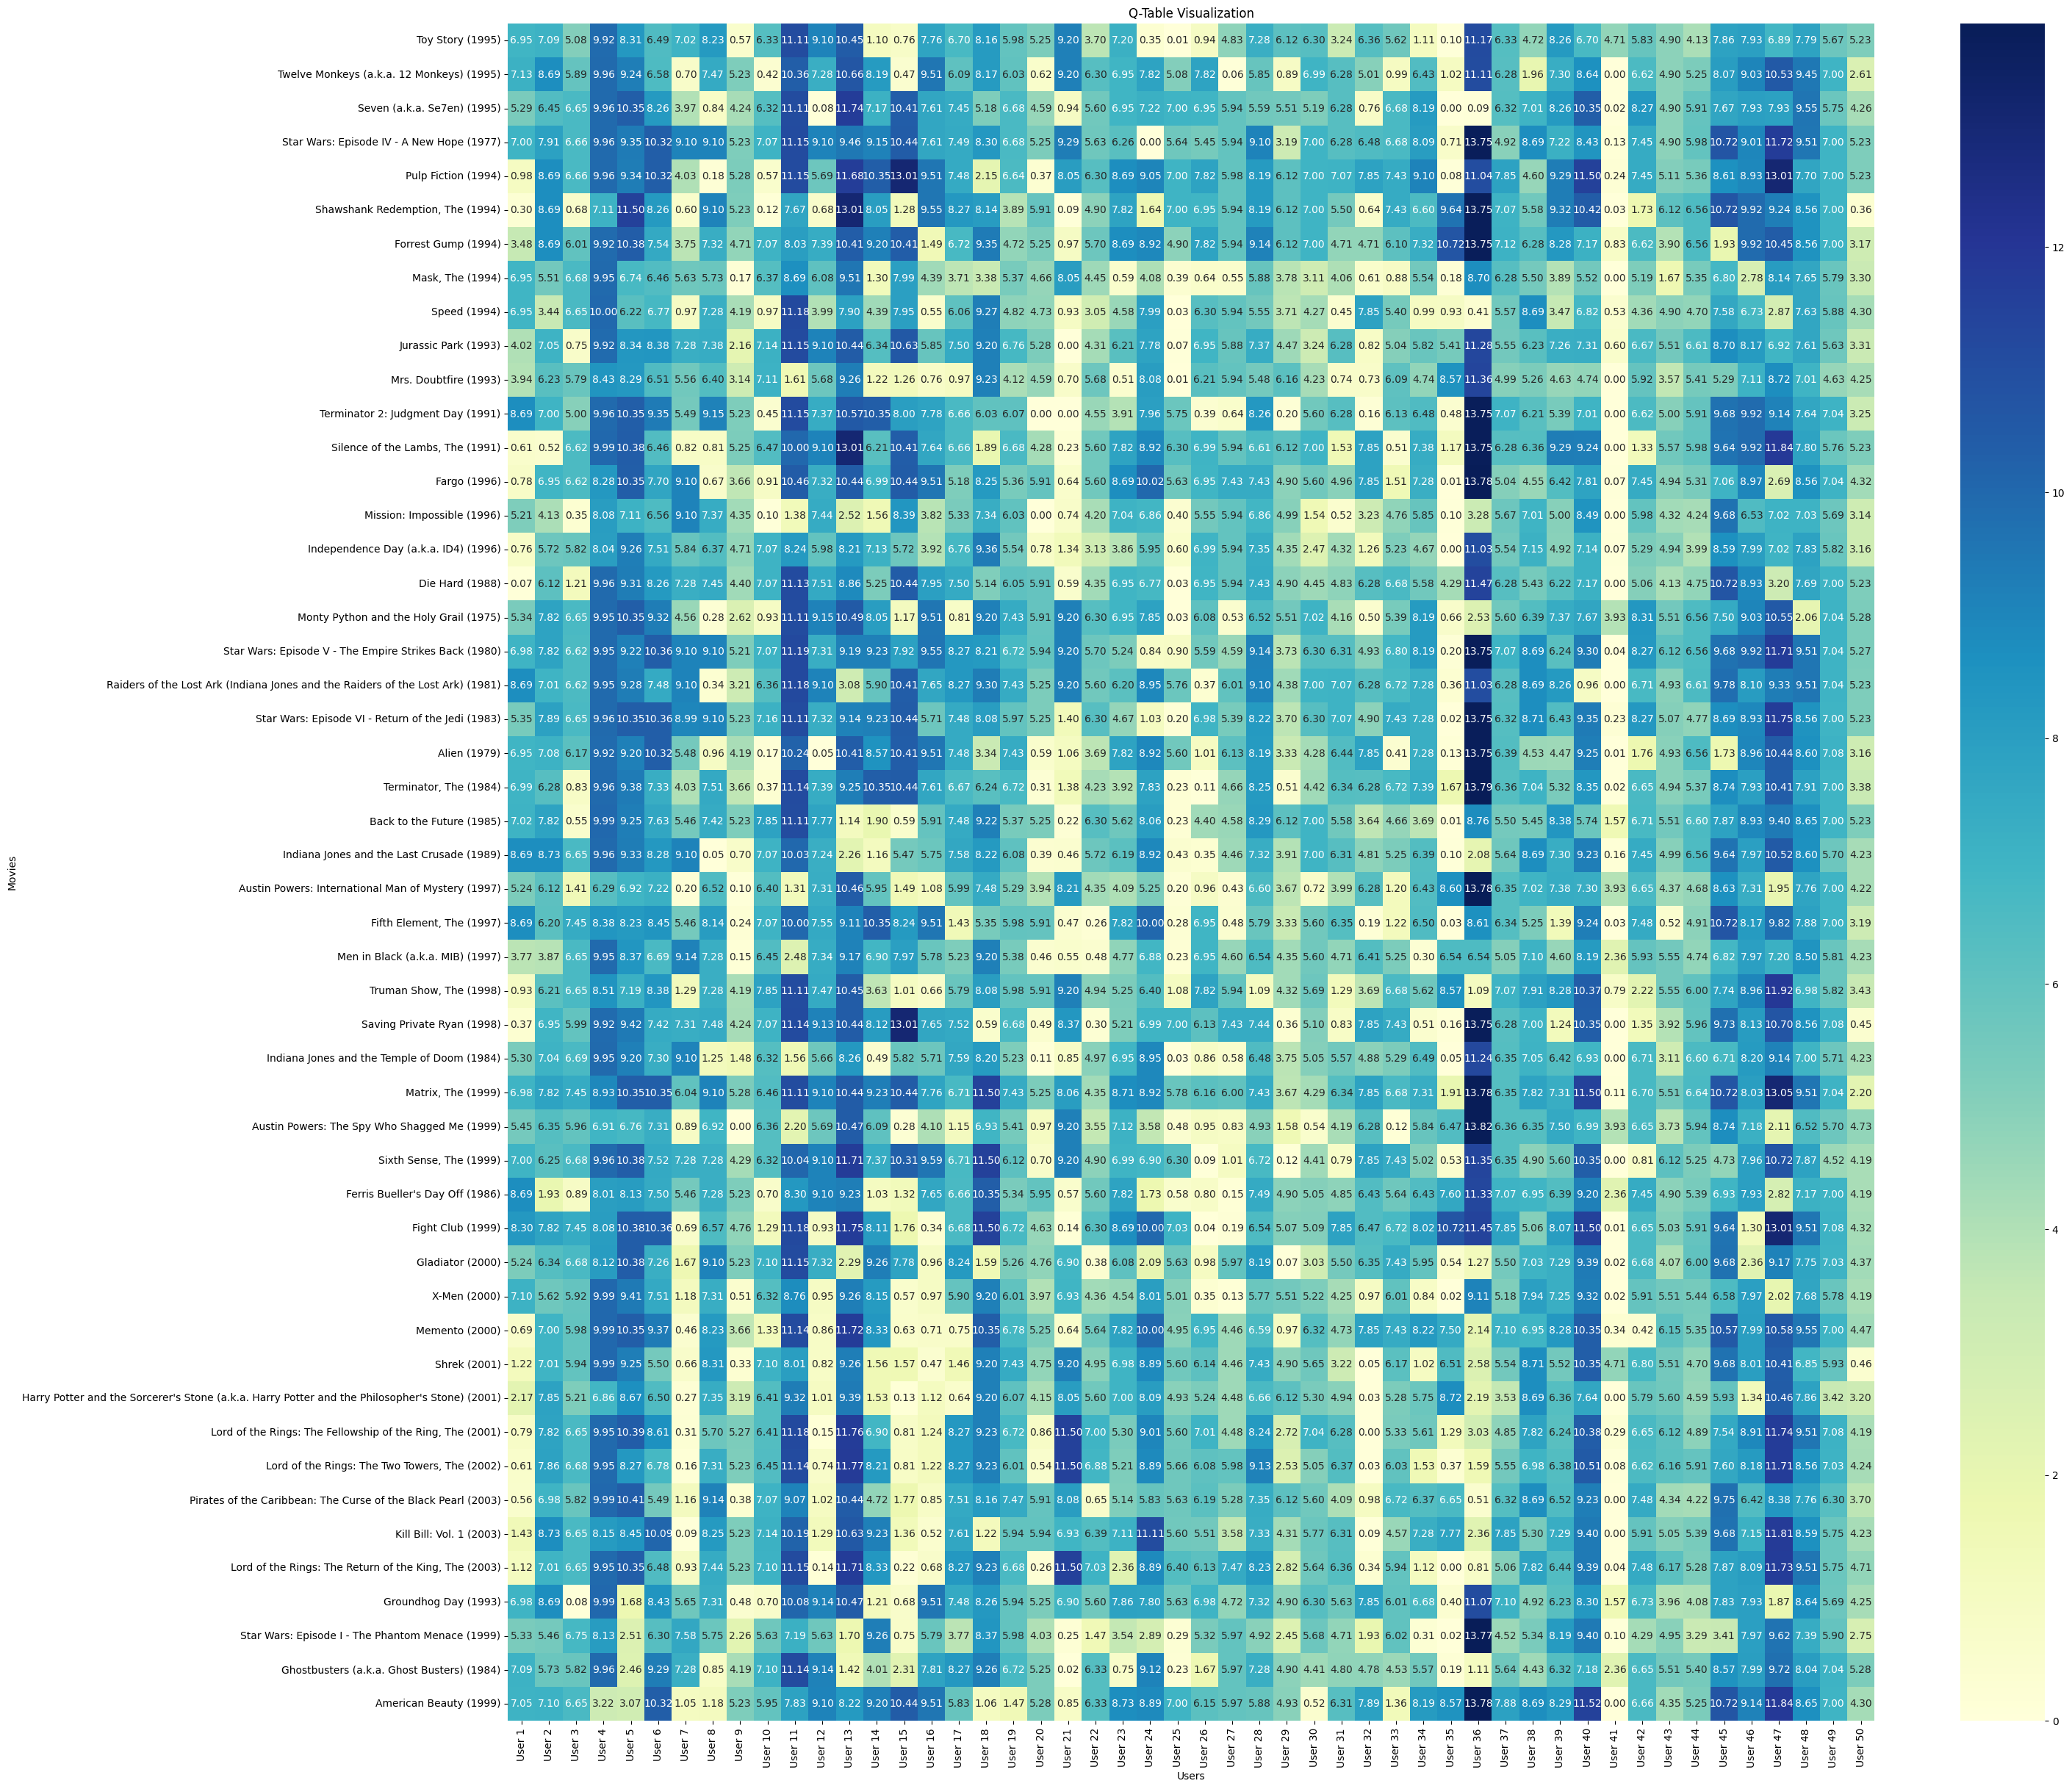

In [9]:
# Визуализация Q-таблицы
q_table_df = pd.DataFrame(Q, index=movies_list)
q_table_df.columns = users
plt.figure(figsize=(30, 30))
sns.heatmap(q_table_df, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Q-Table Visualization')
plt.xlabel('Users')
plt.ylabel('Movies')
plt.show()

### Ух ты, база данных содержит идентификаторы фильмов из TMDb

In [10]:
# Функция формирования ссылки на сайт The Movie Database (TMDb)
def imdb_url(imdb_id):
    imdb_id_str = str(imdb_id).zfill(7) # Дополняется до 7 цифр
    return f"https://www.imdb.com/title/tt{imdb_id_str}/"

In [11]:
# 1. Чтение ссылок на фильмы из базы данных
links = pd.read_csv('ml-latest-small/links.csv')
# 2. Объединение бд фильмов с бд ссылок
movies_with_links = movies[['movieId', 'title', 'genres']].merge(links, on='movieId', how='left')
# 3. Отбор ссылок выбранных фильмов
selected_movies = movies_with_links[movies_with_links['title'].isin(movies_list)]
# 4. Вывод ссылок на фильмы
for idx, row in selected_movies.iterrows():
    print(f"Фильм: {row['title']}, Жанры: {row['genres']}")
    print(f"IMDb страница: {imdb_url(row['imdbId'])}")
    print("=" * 140)

Фильм: Toy Story (1995), Жанры: Adventure|Animation|Children|Comedy|Fantasy
IMDb страница: https://www.imdb.com/title/tt0114709/
Фильм: Twelve Monkeys (a.k.a. 12 Monkeys) (1995), Жанры: Mystery|Sci-Fi|Thriller
IMDb страница: https://www.imdb.com/title/tt0114746/
Фильм: Seven (a.k.a. Se7en) (1995), Жанры: Mystery|Thriller
IMDb страница: https://www.imdb.com/title/tt0114369/
Фильм: Star Wars: Episode IV - A New Hope (1977), Жанры: Action|Adventure|Sci-Fi
IMDb страница: https://www.imdb.com/title/tt0076759/
Фильм: Pulp Fiction (1994), Жанры: Comedy|Crime|Drama|Thriller
IMDb страница: https://www.imdb.com/title/tt0110912/
Фильм: Shawshank Redemption, The (1994), Жанры: Crime|Drama
IMDb страница: https://www.imdb.com/title/tt0111161/
Фильм: Forrest Gump (1994), Жанры: Comedy|Drama|Romance|War
IMDb страница: https://www.imdb.com/title/tt0109830/
Фильм: Mask, The (1994), Жанры: Action|Comedy|Crime|Fantasy
IMDb страница: https://www.imdb.com/title/tt0110475/
Фильм: Speed (1994), Жанры: Action|